In [5]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d

import napari

def plane(X, a, b, c):
    return(a*X[0] + b * X[1] + c)

def delayed_exponential_on(t, b, tau, upper_lim, lower_lim):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b*(t - tau))
    de[t < tau] = lower_lim
    return(de)


def delayed_exponential_on_off(t, b_on, b_off, tau_on, tau_off, upper_lim, lower_lim, lower_lim2):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(t - tau_on))
    de[t < tau_on] = lower_lim
    
    val = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(tau_off - tau_on))
    de[t > tau_off] =  lower_lim2 + (val - lower_lim2) * np.exp(b_off*(t[t > tau_off] - tau_off))
    return(de)


def plane(X, a, b, c):
    '''equation for a plane for approximating background subtractions in cropped microscope images'''
    return(a*X[0] + b * X[1] + c)


class simpleStimData:
    '''
    class for interpreting data saved on the microscope during live-cell tracking and computer-
    generated opto experiments. Contains information about the state of the microscope, the images
    themselves, and has methods for background subtraction and some basic processing
    '''
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        
        
class mm_microscope_image:
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = None
        self.elapsed_time_s = None
        self.channel = None
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            
def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)

class mm_acquisition:
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            print("Problem with LED metadata")
            
        for i in np.sort(os.listdir(self.acq_path)):
            try:
                i = i.decode()
            except:
                pass
            
            if '.tif' in i:
                img_obj = mm_microscope_image(self.acq_path + '/' + i)
                
                try:
                    name_fragments = i.split('_')
                    img_obj.framenumber = int(name_fragments[3][4:])
                    img_obj.channel = int(name_fragments[1][7:])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                    img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                    img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                except:
                    pass
                
                    
                self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 100]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 100]
        
# convenience function for writing out arrays in an easy-to copy-paste format
def ar_to_txt(myarray):
    txt = ''
    for i in myarray:
        txt += str(np.round(i, 2)) + ', '
    print(txt)
    

# Figure S10A

In [2]:
trt1 = mm_acquisition('data/figs10data/cdc42ko_plus_lat/210717_35-52-mCPAK_PLB_CdcKO_10uMLat_TIRF_StepResponse_1')
trt2 = mm_acquisition('data/figs10data//cdc42ko_plus_lat/210717_35-52-mCPAK_PLB_CdcKO_10uMLat_TIRF_StepResponse_2')

78


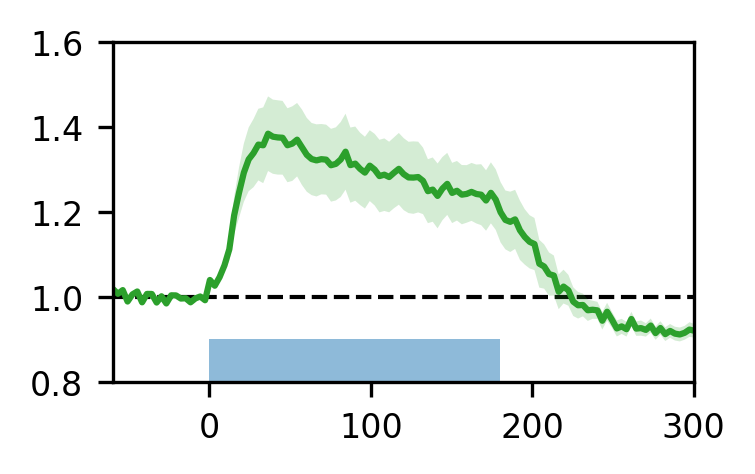

In [3]:
ch0_1 = np.array([i/np.average(i[40:60]) for i in trt1.single_cell_ch0_filtered])
ch0_2 = np.array([i/np.average(i[40:60]) for i in trt2.single_cell_ch0_filtered])
ch0 = np.vstack([ch0_1, ch0_2])

filter2 = np.max(ch0[:,60:], axis = 1)
ch0_responders = ch0[filter2 > 1]
T = trt1.elapsedtimes - trt1.led_timepoints_sec[np.where(trt1.led_data.ledvalues > 0)[0][0]]

plt.figure(figsize = (2.5, 1.5), dpi = 300)
m = np.average(ch0_responders, axis = 0)
s = 1.96 * np.std(ch0_responders, axis = 0) / np.sqrt(len(ch0))
plt.plot(T, m, color = 'C2', zorder = 1)
plt.fill_between(T, m - s, m + s, alpha=0.2, facecolor = 'C2', zorder = 1)
plt.axis([-60, 300, 0.8, 1.5])

plt.fill_between(np.linspace(0, 180, 10), 0.8,0.9, facecolor = 'C0', alpha = 0.5, zorder = -1)
plt.xticks([0, 100, 200, 300], fontsize = 8)
plt.yticks([0.8, 1.0, 1.2, 1.4, 1.6], fontsize = 8)
len(ch0)
plt.axhline(1, color = 'k', ls = '--', zorder = -1, lw = 1)

print(len(ch0))

# Figure S10B

In [6]:
filename = 'data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_002'
a = simpleStimData(filename)

0


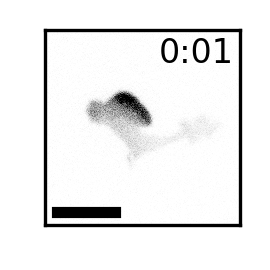

8


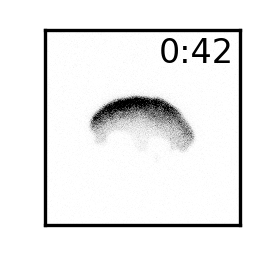

16


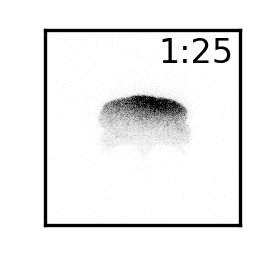

24


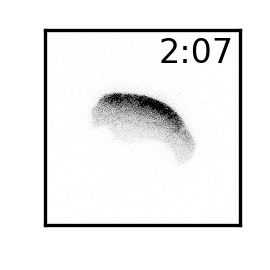

32


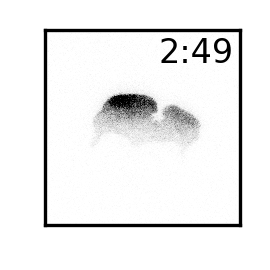

40


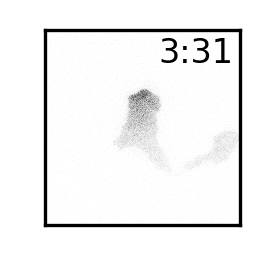

In [7]:
count = 1
for i in range(0, 41, 8):
    print(i)
    plt.figure(figsize = (1, 1), dpi = 300)

    ax = plt.subplot(1, 1, 1, aspect = 'equal')
    xx, yy = a.get_transformed_xy_coords(i) # rotate to standardize initial direction of cell motion
    F = a.ch0_stack[i].copy() - a.ch0_estimated_bg
    plt.pcolormesh(xx, yy, F, vmin = 0, vmax = 2500, cmap = 'Greys') #show pixel data

    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)
    
    xc = a.x_rotated[i]
    yc = a.y_rotated[i]
    D = 30
    if count == 1:
        rect = mp.Rectangle((xc - D + 3, yc - D + 3), 20, 2, color = 'k')
        ax.add_patch(rect)
        
    M = str(int(round(a.ch0_times[i]//60)))
    S = str(int(round(a.ch0_times[i]%60))).zfill(2)
    text = M + ':' + S
    ax.text(xc + D - 2, yc + D - 2, text, ha = 'right', va = 'top', fontsize = 8)
    plt.axis([xc - D, xc + D, yc - D, yc + D])
    count += 1
    plt.tight_layout()
    plt.show()



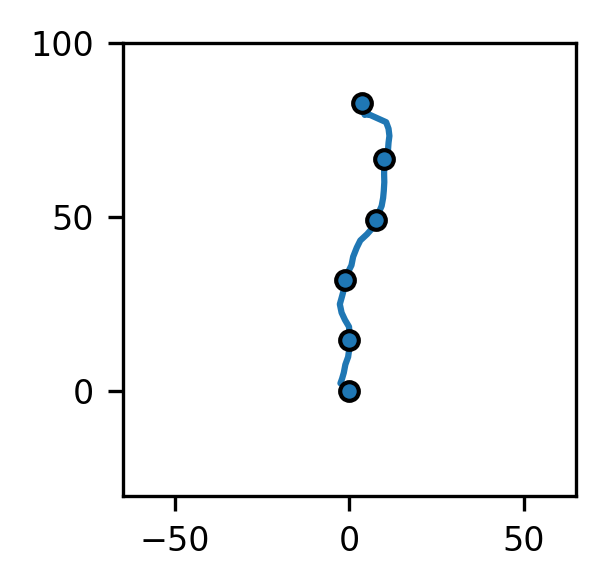

In [8]:
plt.figure(figsize = (2, 2), dpi = 300)
plt.subplot(aspect = 'equal')
plt.plot(a.x_rotated[:50] - a.x_rotated[0], a.y_rotated[:50] - a.y_rotated[0], zorder = -1)

for i in range(0, 41, 8):
    plt.scatter(a.x_rotated[i] - a.x_rotated[0], a.y_rotated[i] - a.y_rotated[0], color = 'C0', s = 20, ec = 'k', zorder = 0)
plt.axis([-65, 65, -30, 100])
plt.yticks([0, 50, 100], fontsize = 8)
plt.xticks([-50, 0, 50], fontsize = 8)
#plt.tight_layout()
plt.show()

In [16]:
# Collect paths to data in memory - this is needed to run most code blocks below
# select unique identifiers of the various test conditions for folders inside parent_dir

DATA = []
for condition in different_conditions:
    print(f'finding paths containing: "{condition}"' + '\n')
    # collect local list of paths to experiments to pool together for display
    for i in os.listdir('data/figs10data/cdc42ko_none/'):
        if (condition in i):
            print(i)
            DATA.append('data/figs10data/cdc42ko_none/' + i)

DATA = np.array(DATA)
for condition in different_conditions:
    print(condition, np.sum([condition in i for i in DATA]))

finding paths containing: "PLB"

210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_004
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_011
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_009
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_006
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_007
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_000
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_012
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_002
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_005
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_008
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_010
210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_001
PLB 12


finding paths containing: "PLB"

data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_004 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_011 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_009 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_006 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_007 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_000 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_012 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_002 600
data/figs10data/cdc42ko_none/210928_PLB_Cdc42KO_35-52-mcPAK_0nmFMLP_observeGlobalFlash_refocus_005 600
data/figs10data/cdc42ko_none/210928_PLB_

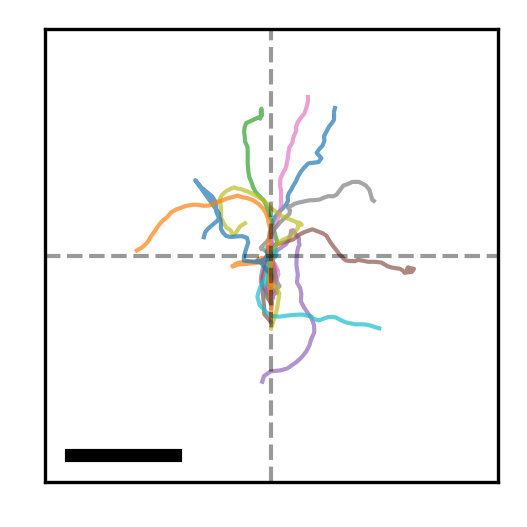

In [17]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################


different_conditions = ['PLB']


exp_cond = []
file_id = []
file_id_num = []
frame = []
time = []
x_um = []
y_um = []

for condition in different_conditions:
    
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    
    if (condition == '_lateral90_'):
        for i in DATA:
            if (condition in i) or ('_0Rad_' in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)
        
    else:
        for i in DATA:
            if (condition in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)

                
                
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    

    # instantiate a figure
    plt.figure(figsize = (2,2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')
    
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        print(exp_to_analyze[fnum])

        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder - something strange happens with some filenames and these need to be "decoded"
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        # fluorescence channel
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []
        t_stage_sequence = []
        
        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])
                tval = float(temptif.shaped_metadata[0]['elapsed_time_s'])
                
                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
                t_stage_sequence.append(tval)
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        
        
        t_cutoff = np.where(np.array(t_stage_sequence) > 250)[0][0]
        print(t_cutoff)
        plt.plot(-x_rotated[:t_cutoff], y_rotated[:t_cutoff], alpha = 0.7, lw = 1)
        ALL_X_PATHS.append(-x_rotated[:t_cutoff])
        ALL_Y_PATHS.append(y_rotated[:t_cutoff])
         
        for ix in range(len(x_rotated)):
            exp_cond.append('unstimulated')
            file_id.append(exp_to_analyze[fnum].split('/')[-1])
            file_id_num.append(fnum)
            frame.append(ix)
            time.append(t_stage_sequence[ix])
            x_um.append(x_rotated[ix])
            y_um.append(y_rotated[ix])

    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axis([-100, 100, -100, 100])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)



    rect = mp.Rectangle((-90, -90), 50, 4, color = 'k')
    ax.add_patch(rect)
    #ax.text(-120 + 50/2, -110, '50 µm', ha = 'center', va = 'bottom', fontweight='bold')
    plt.show()
    #txt = str(np.round(a.ch0_times[i] - a.ch0_times[10], 1))
    #ax.text(-100, 115, txt + ' s', va = 'top', ha = 'right', fontweight='bold')


# Figure S10C

In [14]:
filename = 'data/figs10data/cdc42ko_turn/210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_004'
a = simpleStimData(filename)

/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


0


/tmp/ipykernel_4668/1099710286.py:11: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, a.ch4_stack[i] > 0, levels = [False], colors = 'C0', linewidths = 0.7)


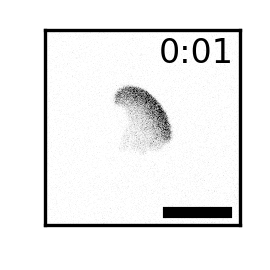

8


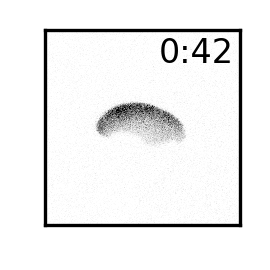

16


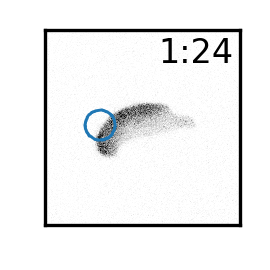

24


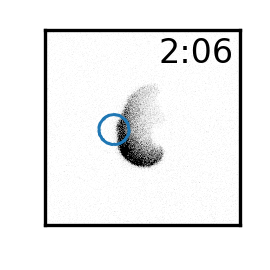

32


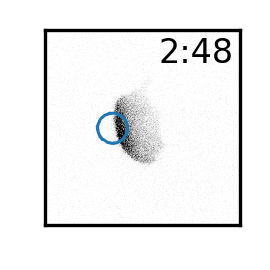

40


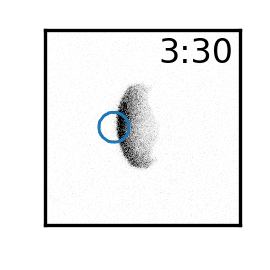

In [15]:

count = 1
for i in range(0, 41, 8):
    print(i)
    plt.figure(figsize = (1, 1), dpi = 300)

    ax = plt.subplot(1, 1, 1, aspect = 'equal')
    xx, yy = a.get_transformed_xy_coords(i) # rotate to standardize initial direction of cell motion
    F = a.ch0_stack[i].copy() - a.ch0_estimated_bg
    plt.pcolormesh(xx, yy, F, vmin = 0, vmax = 1500, cmap = 'Greys') #show pixel data
    
    plt.contour(xx, yy, a.ch4_stack[i] > 0, levels = [False], colors = 'C0', linewidths = 0.7)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)
    
    xc = a.x_rotated[i]
    yc = a.y_rotated[i]
    D = 30
    if count == 1:
        rect = mp.Rectangle((xc - D + 3, yc - D + 3), 20, 2, color = 'k')
        ax.add_patch(rect)
        
    M = str(int(round(a.ch0_times[i]//60)))
    S = str(int(round(a.ch0_times[i]%60))).zfill(2)
    text = M + ':' + S
    ax.text(xc - D + 2, yc + D - 2, text, ha = 'right', va = 'top', fontsize = 8)
    plt.axis([xc + D, xc - D, yc - D, yc + D])
    count += 1
    plt.tight_layout()
    plt.show()




In [12]:
# Collect paths to data in memory - this is needed to run most code blocks below
# select unique identifiers of the various test conditions for folders inside parent_dir
different_conditions = ['turn']

DATA = []
for condition in different_conditions:
    print(f'finding paths containing: "{condition}"' + '\n')
    # collect local list of paths to experiments to pool together for display
    for i in os.listdir('data/figs10data/cdc42ko_turn/'):
        if (condition in i):
            print(i)
            DATA.append('data/figs10data/cdc42ko_turn/' + i)

DATA = np.array(DATA)
for condition in different_conditions:
    print(condition, np.sum([condition in i for i in DATA]))

finding paths containing: "turn"

210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_006
210805_PLB_Cdc42KO_35-52-mcPAK_turningAssay_catchAndFlash_006
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_015
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_008
210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_000
210805_PLB_Cdc42KO_35-52-mcPAK_turningAssay_catchAndFlash_003
210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_003
210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_002
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_000
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_009
210805_PLB_Cdc42KO_35-52-mcPAK_turningAssay_catchAndFlash_000
210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_004
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_013
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_010
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_005
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_012
210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_007
210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_001
turn 18


finding paths containing: "PLB"

data/figs10data/cdc42ko_turn/210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_006 360
data/figs10data/cdc42ko_turn/210805_PLB_Cdc42KO_35-52-mcPAK_turningAssay_catchAndFlash_006 480
data/figs10data/cdc42ko_turn/210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_015 360
data/figs10data/cdc42ko_turn/210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_008 360
data/figs10data/cdc42ko_turn/210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_000 360
data/figs10data/cdc42ko_turn/210805_PLB_Cdc42KO_35-52-mcPAK_turningAssay_catchAndFlash_003 480
data/figs10data/cdc42ko_turn/210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_003 360
data/figs10data/cdc42ko_turn/210726_PLB_Cdc42KO_35-52-mcPAK_turningAssay_002 360
data/figs10data/cdc42ko_turn/210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_000 360
data/figs10data/cdc42ko_turn/210726_PLB_cdc42ko_35-52-mcPAK_turningAssay_2_009 360
data/figs10data/cdc42ko_turn/210805_PLB_Cdc42KO_35-52-mcPAK_turningAssay_catchAndFlash_000 480
data/figs10data/cdc42ko_

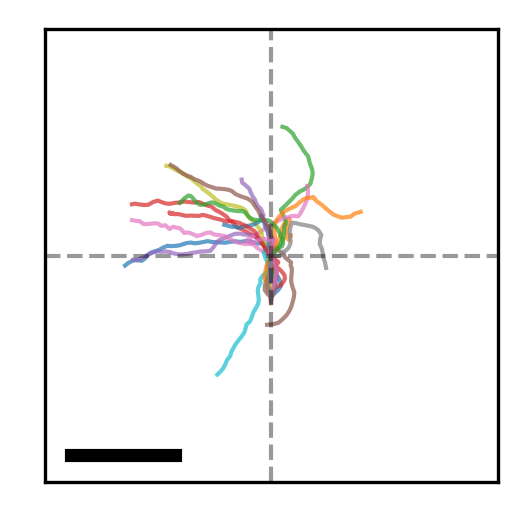

In [13]:
##################################################################################################
# Generate overlay plots of the stage coordinates for each of the sub-type of experiment
# for example, different delays or intensities for the spot introductions
# Must run code block above to identify the parent directory
##################################################################################################


different_conditions = ['PLB']

for condition in different_conditions:
    
    ALL_X_PATHS = []
    ALL_Y_PATHS = []

    final_lateral_pos = []
    ids = []

    print(f'finding paths containing: "{condition}"' + '\n')
    
    # collect local list of paths to experiments to pool together for display
    exp_to_analyze = []
    
    
    if (condition == '_lateral90_'):
        for i in DATA:
            if (condition in i) or ('_0Rad_' in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)
        
    else:
        for i in DATA:
            if (condition in i):
                num_img = len(os.listdir(i))
                if num_img >= 300:
                    print(i, num_img)
                    exp_to_analyze.append(i)

                
                
    print(len(exp_to_analyze))
    
    # sort the folders alphabetically (optional)
    exp_to_analyze = np.sort(exp_to_analyze)
    

    # instantiate a figure
    plt.figure(figsize = (2,2), dpi = 300)
    ax = plt.subplot(aspect = 'equal')
    
    # loop over folders that contain the text from the list of different_conditions
    for fnum in range(len(exp_to_analyze)):
        print(exp_to_analyze[fnum])

        foldername = exp_to_analyze[fnum]
        
        # collect image paths within the folder - something strange happens with some filenames and these need to be "decoded"
        try:
            im_path_list = np.sort([foldername + '/' + i for i in np.sort(os.listdir(foldername))])
        except:
            im_path_list = np.sort([foldername + '/' + i.decode('ascii') for i in np.sort(os.listdir(foldername))])
            
            
        # fluorescence channel
        ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        
        # x and y coordinates for this particular set of images
        x_stage_sequence = []
        y_stage_sequence = []
        t_stage_sequence = []
        
        for i in range(len(ch0_path_list)):
            with tifffile.TiffFile(ch0_path_list[i]) as temptif:
                
                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])
                tval = float(temptif.shaped_metadata[0]['elapsed_time_s'])
                
                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)
                t_stage_sequence.append(tval)
                
        # convert to numpy arrays to make translation and rotation a little easier
        x_stage_sequence = np.array(x_stage_sequence)
        y_stage_sequence = np.array(y_stage_sequence)
        
        # calculate the initial direction of the cell in the first ten frames
        x_translated = x_stage_sequence - x_stage_sequence[10] 
        y_translated = y_stage_sequence - y_stage_sequence[10]
        rotation_angle = np.arctan2(-np.average(np.diff(y_translated[:11])), np.average(np.diff(x_translated[:11])))
        
        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - rotation_angle + math.pi/2

        x_rotated = rho * np.cos(phi)
        y_rotated = rho * np.sin(phi)
        
        
        t_cutoff = np.where(np.array(t_stage_sequence) > 250)[0][0]
        print(t_cutoff)
        plt.plot(-x_rotated[:t_cutoff], y_rotated[:t_cutoff], alpha = 0.7, lw = 1)
        ALL_X_PATHS.append(-x_rotated[:t_cutoff])
        ALL_Y_PATHS.append(y_rotated[:t_cutoff])
         
        for ix in range(len(x_rotated)):
            exp_cond.append('unstimulated')
            file_id.append(exp_to_analyze[fnum].split('/')[-1])
            file_id_num.append(fnum)
            frame.append(ix)
            time.append(t_stage_sequence[ix])
            x_um.append(x_rotated[ix])
            y_um.append(y_rotated[ix])

    plt.axhline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axvline(0, ls = '--', color = 'k', alpha = 0.4, lw = 1)
    plt.axis([-100, 100, -100, 100])
    #plt.xlabel('X Position (µm)', fontweight = 'bold', fontsize = 8)
    #plt.ylabel('Y Position (µm)', fontweight = 'bold', fontsize = 8)
    plt.xticks([], fontsize = 5)
    plt.yticks([], fontsize = 5)



    rect = mp.Rectangle((-90, -90), 50, 4, color = 'k')
    ax.add_patch(rect)
    #ax.text(-120 + 50/2, -110, '50 µm', ha = 'center', va = 'bottom', fontweight='bold')
    plt.show()
    #txt = str(np.round(a.ch0_times[i] - a.ch0_times[10], 1))
    #ax.text(-100, 115, txt + ' s', va = 'top', ha = 'right', fontweight='bold')
